In [1]:
import pygeostat as gs
from hier_bound_sim_helpers import *

In [2]:
jura = gs.DataFile(flname='data/jura_m.dat', x='Xloc', y='Yloc')

In [3]:
jura.head()

,Xloc,Yloc,Landuse,Rock,Cd,Co,Cr,Cu,Ni,Pb,Zn
0,238.6,307.7,3.0,3.0,1.740,9.32,38.32,25.72,21.32,77.36,92.56
1,254.4,197.2,2.0,2.0,1.335,10.00,40.20,24.76,29.72,77.88,73.56
2,280.7,334.7,2.0,3.0,1.610,10.60,47.00,8.88,21.40,30.80,64.80
3,430.8,193.3,3.0,2.0,2.150,11.92,43.52,22.70,29.72,56.40,90.00
4,438.3,108.1,3.0,5.0,1.565,16.32,38.52,34.32,26.20,66.40,88.40


In [4]:
cat_dict = {1: 'Argovian',
            2: 'Kimmeridgian',
            3: 'Sequian',
            4: 'Portlandian',
            5: 'Quartenary'}

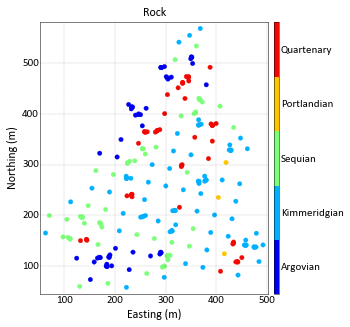

In [5]:
_ = gs.location_plot(jura, var='Rock', grid=True, catdict=cat_dict, cmap='jet', output_file='images/points.png', figsize=(5,5))

In [6]:
grid = jura.infergriddef(blksize=[10,10,1])

In [7]:
rbfdfmod = gs.Program('RBFDFMOD/rbfdfmod.exe', getpar=True)

D:\Google Drive\Academia\papers\bound simulation hierarchical approach\Notebooks\tmp7eh6kq5a\rbfdfmod.par has been copied to the clipboard


In [8]:
parstr = """                        rbfdfmod
                        ********

START OF PARAMETERS:
{flname}                -file with input dataset
1  2 0  4               - column for x, y, z, indicator data
-999                     - trimming value
5 1 2 3 4 5                  -ncats, category indicator
keyout.dat               -file with the keyout model
1  1                     - column for keyout variable, value to keep
{grid}
1  0  0  0 0 0               -RBFinterp type (1:direct, 2:POU)-NOTE 1, trained C parameter(s)-NOTE 3
1  0.001                 - RBF kernel (NOTE 2), Nugget Effect
1  45  45              - Support (0:manual,1:auto) - NOTE 2, support distance, extrapolation distance
0                        -Use different anisotropy for each category? (1=Yes,0=No) - NOTE 4
0  0  0                  - Anisotropic orientations (str,dip,plunge) / Cat1
1  1                     - Anisotropic ratios (minor/major, vertical/major, <= 1.0)
1    6                   -Ouput: (1) indicators or (2) signed distacnce function, numthreads for parallel SDF
Outputs/jura_outfl.out                -file for interpolated output
*** BPT parameter section: ***  
95  0.06  1              -Partition paramters: dpc, d overlap, weight func (1 or 2, see paper)
 0.5 0.5 0.5             - final partition overlap in x, y, z directions
0                        -read BPT parameters from file(1=Yes,0=No) - NOTE 6
BPT_bounds.out           -file with partition boundaries
BPT_aniso_cat2_ref4.out  -file(s) with anisotropy for each category

NOTES:
1  -   the supported types of interpolation in this program are 1:direct (slow for > 15k data),
       2:POU (>15k data). Regardless of interpolation type, all lines are required (do not remove
       lines from this parameter file,  simply ignore those parameters)
2  -   Valid Kernels: 1:Gaussian,2:Cubic,3:Wendland C2,4:Linear,5:Spherical
       Caution: NE with RBFs is problematic. Use with Caution. A small (0.0001) NE added to Gaussian by default
       For a kernel that has a support parameter (Gaussian, Wendlands), the support distance defines the
       range at which the influence of points is negligeble. Setting the support option to 1 estimates
       the support distance from the max distance from any grid cell to its nearest data, over the whole domain.
       In the case of partition of unity interpolation, this parameter is estimated locally for each
       partition.
3  -   One C-parameter is required for each category. Specifying the value of the trained C paramter will
       interpolate the SDF problem by considering that parameter in the calculated distance function.
       The interpolated SDF from this program will have the correct volume according to that trained C parameter
       (Wilde and Deutsch, 2011)
4  -   If this option is set to 1, you must provide anisotropic parameter sets for each category
       indicated on line 8 on the following lines by reproducing the following 2 lines and pasting them
       immediately below for each needed set of anisotropic parameters.
       0  0  0                        - Anisotropic orientations (str,dip,plunge) / Cat_N
       1  1                           - Anisotropic ratios (minor/major, vertical/major, <= 1.0)
5  -   The resulting .h5 file will contain all required configuration information including solved weights
       so that the interpolant can be re-evaluated without re-solving the problem. This will include
       all partitioning and configuration properties.. to be used in the rbfextract program 
6  -   Set option to 1 to read boundaries and anisotropic partition parameters from a trained file output by
       the rbfiterref program. Use this option to read in those parameters and interpolate the problem with the
       trained c parameter from the rbfuncert program.



"""

parstr = parstr.format(flname=jura.flname, grid=grid)

rbfdfmod.run(parstr=parstr, liveoutput=True)

Calling:  ['RBFDFMOD/rbfdfmod.exe', 'temp']
 rbfdfmod, version :  2.00
Datafile: data/jura_m.dat                         
 xcol,ycol and zcol and datcol:   1  2  0  4
 interpolation is 2D, since zcol = 0 
 trimming limit:         -999.00
 categories to model:          1         2         3         4         5
 nx, xmn, xsiz =   44        62.0000          10.0000
 ny, ymn, ysiz =   53        58.0000          10.0000
 nz, zmn, zsiz =    1         0.5000           1.0000
 Interpolation Type:  Direct              
 Kernel Type: Gaussian            
Automatically determining support from data spacing
Will only consider grid locations falling within this
  distance from data:    45.000000    
 Using one set of aniostropic properties for all categories 
 Using the following for all categories: 
Using these angles:          0.0000000       0.0000000       0.0000000    
 minor/major, vert/major:    1.0000000       1.0000000    
Exporting an indicator grid
File to write outputs to: Outputs/jura_

In [9]:
geomodel = gs.DataFile('Outputs/jura_outfl.out', griddef=grid)

In [10]:
geomodel.head()

,Cat
0,NaN
1,NaN
2,NaN
3,3.0
4,3.0


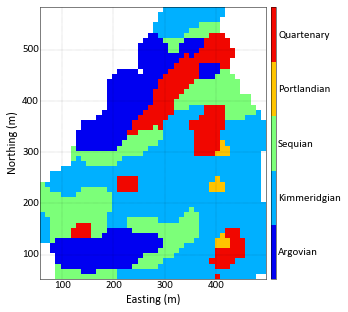

In [11]:
_ = gs.slice_plot(geomodel, 
                  var='Geologic map', 
                  cmap='jet', 
                  catdict=cat_dict, 
                  figsize=(5,5), 
                  grid=True, 
                  output_file='images/geomodel.png')

In [12]:
c_delim, maps = grouping(df=jura, rock='Rock', grid=grid, prop=geomodel['Cat'])

Marching the cubes...
2D
Counting contacts...
Contacts count:  {(2.0, 3.0): 134, (1.0, 3.0): 74, (2.0, 5.0): 66, (1.0, 5.0): 45, (3.0, 5.0): 40, (2.0, 4.0): 23, (4.0, 5.0): 9, (1.0, 2.0): 8, (1.0, 2.0, 3.0): 7, (1.0, 3.0, 5.0): 6, (2.0, 4.0, 5.0): 4, (2.0, 3.0, 5.0): 4}
Done!


In [13]:
maps

{'g1': {2.0: 1, 3.0: 1, 5.0: 0, 1.0: 0, 4.0: 0},
 'g2': {2.0: 1, 3.0: 0},
 'g3': {1.0: 1, 5.0: 1, 4.0: 0},
 'g4': {1.0: 1, 5.0: 0}}

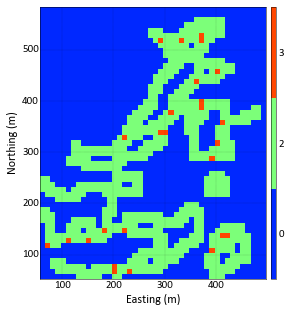

In [14]:
_ = gs.slice_plot(c_delim, 
                  griddef=grid,
                  cmap='jet', 
                  figsize=(5,5), 
                  grid=True, 
                  output_file='images/cdelim.png')

In [15]:
groups = df_groups(maps=maps, df=jura, rock='Rock')

In [16]:
groups['g1'].head()

,Xloc,Yloc,Landuse,Rock,Cd,Co,Cr,Cu,Ni,Pb,Zn
0,238.6,307.7,3.0,1,1.740,9.32,38.32,25.72,21.32,77.36,92.56
1,254.4,197.2,2.0,1,1.335,10.00,40.20,24.76,29.72,77.88,73.56
2,280.7,334.7,2.0,1,1.610,10.60,47.00,8.88,21.40,30.80,64.80
3,430.8,193.3,3.0,1,2.150,11.92,43.52,22.70,29.72,56.40,90.00
4,438.3,108.1,3.0,0,1.565,16.32,38.52,34.32,26.20,66.40,88.40


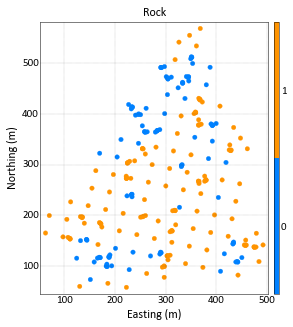

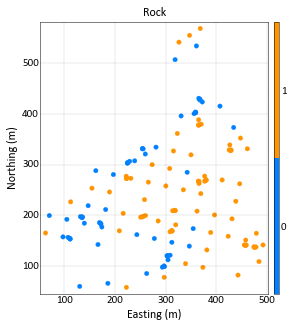

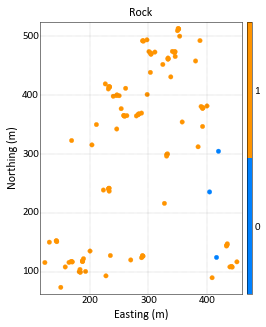

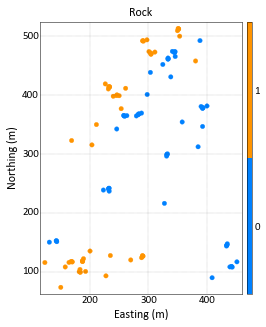

In [17]:
dfg = {}
for g in groups:
    datafileg = gs.DataFile(data=groups[g], x='Xloc', y='Yloc')
    datafileg.write_file(flname='data/data_{}'.format(g), fltype='gslib')
    datafileg = gs.DataFile(flname='data/data_{}'.format(g), x='Xloc', y='Yloc')
    dfg[g] = datafileg
    _ = gs.location_plot(datafileg, var='Rock', grid=True, cmap='jet', output_file='images/g{}.png'.format(g), figsize=(5,5))

In [18]:
grid = jura.infergriddef(blksize=[3,3,1])

In [19]:
parstr = """                        rbfdfmod
                        ********

START OF PARAMETERS:
{flname}                -file with input dataset
1  2 0  4               - column for x, y, z, indicator data
-999                     - trimming value
5 1 2 3 4 5                  -ncats, category indicator
keyout.dat               -file with the keyout model
1  1                     - column for keyout variable, value to keep
{grid}
1  0  0  0 0 0               -RBFinterp type (1:direct, 2:POU)-NOTE 1, trained C parameter(s)-NOTE 3
1  0.001                 - RBF kernel (NOTE 2), Nugget Effect
1  45  45              - Support (0:manual,1:auto) - NOTE 2, support distance, extrapolation distance
0                        -Use different anisotropy for each category? (1=Yes,0=No) - NOTE 4
0  0  0                  - Anisotropic orientations (str,dip,plunge) / Cat1
1  1                     - Anisotropic ratios (minor/major, vertical/major, <= 1.0)
1    6                   -Ouput: (1) indicators or (2) signed distacnce function, numthreads for parallel SDF
Outputs/jura_outfl_mask.out                -file for interpolated output
*** BPT parameter section: ***  
95  0.06  1              -Partition paramters: dpc, d overlap, weight func (1 or 2, see paper)
 0.5 0.5 0.5             - final partition overlap in x, y, z directions
0                        -read BPT parameters from file(1=Yes,0=No) - NOTE 6
BPT_bounds.out           -file with partition boundaries
BPT_aniso_cat2_ref4.out  -file(s) with anisotropy for each category

NOTES:
1  -   the supported types of interpolation in this program are 1:direct (slow for > 15k data),
       2:POU (>15k data). Regardless of interpolation type, all lines are required (do not remove
       lines from this parameter file,  simply ignore those parameters)
2  -   Valid Kernels: 1:Gaussian,2:Cubic,3:Wendland C2,4:Linear,5:Spherical
       Caution: NE with RBFs is problematic. Use with Caution. A small (0.0001) NE added to Gaussian by default
       For a kernel that has a support parameter (Gaussian, Wendlands), the support distance defines the
       range at which the influence of points is negligeble. Setting the support option to 1 estimates
       the support distance from the max distance from any grid cell to its nearest data, over the whole domain.
       In the case of partition of unity interpolation, this parameter is estimated locally for each
       partition.
3  -   One C-parameter is required for each category. Specifying the value of the trained C paramter will
       interpolate the SDF problem by considering that parameter in the calculated distance function.
       The interpolated SDF from this program will have the correct volume according to that trained C parameter
       (Wilde and Deutsch, 2011)
4  -   If this option is set to 1, you must provide anisotropic parameter sets for each category
       indicated on line 8 on the following lines by reproducing the following 2 lines and pasting them
       immediately below for each needed set of anisotropic parameters.
       0  0  0                        - Anisotropic orientations (str,dip,plunge) / Cat_N
       1  1                           - Anisotropic ratios (minor/major, vertical/major, <= 1.0)
5  -   The resulting .h5 file will contain all required configuration information including solved weights
       so that the interpolant can be re-evaluated without re-solving the problem. This will include
       all partitioning and configuration properties.. to be used in the rbfextract program 
6  -   Set option to 1 to read boundaries and anisotropic partition parameters from a trained file output by
       the rbfiterref program. Use this option to read in those parameters and interpolate the problem with the
       trained c parameter from the rbfuncert program.



"""

parstr = parstr.format(flname=jura.flname, grid=grid)

rbfdfmod.run(parstr=parstr, liveoutput=True)

Calling:  ['RBFDFMOD/rbfdfmod.exe', 'temp']
 rbfdfmod, version :  2.00
Datafile: data/jura_m.dat                         
 xcol,ycol and zcol and datcol:   1  2  0  4
 interpolation is 2D, since zcol = 0 
 trimming limit:         -999.00
 categories to model:          1         2         3         4         5
 nx, xmn, xsiz =  147        58.5000           3.0000
 ny, ymn, ysiz =  174        54.5000           3.0000
 nz, zmn, zsiz =    1         0.5000           1.0000
 Interpolation Type:  Direct              
 Kernel Type: Gaussian            
Automatically determining support from data spacing
Will only consider grid locations falling within this
  distance from data:    45.000000    
 Using one set of aniostropic properties for all categories 
 Using the following for all categories: 
Using these angles:          0.0000000       0.0000000       0.0000000    
 minor/major, vert/major:    1.0000000       1.0000000    
Exporting an indicator grid
File to write outputs to: Outputs/jura_

In [20]:
jur_mask = gs.DataFile('Outputs/jura_outfl_mask.out', griddef=grid)

In [21]:
var_calc = gs.Program('VARCALC/varcalc.exe', getpar=True)

D:\Google Drive\Academia\papers\bound simulation hierarchical approach\Notebooks\tmp8nrq2z_k\varcalc.par has been copied to the clipboard


In [22]:
n_lags = 100
lag = 12
lag_tol = lag/2

In [23]:
varcalcpar = parstr = """                  Parameters for VARCALC
                  **********************
 
START OF PARAMETERS:
{flname}                 -file with data
1   2   0                         -   columns for X, Y, Z coordinates
1   {col_num}   {col_num}                         -   number of variables,column numbers (position used for tail,head variables below)
-998.0    1.0e21                  -   trimming limits
1                                 -number of directions
0.0 91 12 0.0 22.5 12 0.0   -Dir 01: azm,azmtol,bandhorz,dip,diptol,bandvert,tilt
 {n_lags}  {lag}  {lag_tol}                 -        number of lags,lag distance,lag tolerance
{outfl}                       -file for experimental variogram points output.
0                                 -legacy output (0=no, 1=write out gamv2004 format)
1                                 -run checks for common errors
1                                 -standardize sills? (0=no, 1=yes)
1                                 -number of variogram types
1   1   10 1   {var}                     -tail variable, head variable, variogram type (and cutoff/category), sill
"""

for ind in [1,2,3,4,]:
    prop = np.sum(dfg['g1']['Rock'])/len(dfg['g1']['Rock'])
    var = prop - prop ** 2
    parstr = varcalcpar.format(flname=dfg['g{}'.format(ind)].flname,
            col_num=dfg['g{}'.format(ind)].gscol('Rock'),
            n_lags=n_lags,
            lag=lag,
            lag_tol=lag_tol,
            var= var,
            outfl='Outputs/out_fl_{}.out'.format(ind))
    
    var_calc.run(parstr=parstr, liveoutput=True)

Calling:  ['VARCALC/varcalc.exe', 'temp']

varcalc version:  1.400

  data file: data/data_g1
  x,y,z columns:            1           2           0
  number of variables:            1
  Variable columns:            4
  tmin,tmax:   -998.000000000000       1.000000000000000E+021
  number of directions:            1
  direction parameters:
 azm,azmtol,bandhorz  0.000000000000000E+000   91.0000000000000     
   12.0000000000000     
 dip,diptol,bandvert  0.000000000000000E+000   22.5000000000000     
   12.0000000000000     
 tilt  0.000000000000000E+000
 nlags,lagdist,lagtol         100   12.0000000000000     
   6.00000000000000     
  output file: Outputs/out_fl_1.out
  legacy output?            0
  run checks?            1
  attempt to standardize sills?            1
  number of variogram types:            1
 Variogram tail,head,type           1           1          10
  cutoff/category   1.00000000000000     
  standardizing with sill =  0.244897959183673     
 Reading data file
 Set

In [24]:
var_model = gs.Program('VARMODEL/varmodel.exe', getpar=True)

D:\Google Drive\Academia\papers\bound simulation hierarchical approach\Notebooks\tmpzjpeay0q\varmodel.par has been copied to the clipboard


In [25]:
varmodelpar = parstr = """                  Parameters for VARMODEL
                  ***********************
 
START OF PARAMETERS:
{model_out}                 -file for modeled variogram points output
1                            -number of directions to model points along
  0.0   0.0  1000   0.5      -  azm, dip, npoints, point separation
2    0:0.1                   -nst, nugget effect
1    ?    0.0   0.0   0.0    -it,cc,azm,dip,tilt (ang1,ang2,ang3)
        ?     ?     ?    -a_hmax, a_hmin, a_vert (ranges)
1    ?    0.0   0.0   0.0    -it,cc,azm,dip,tilt (ang1,ang2,ang3)
        ?     ?     ?    -a_hmax, a_hmin, a_vert (ranges)
1   100000                   -fit model (0=no, 1=yes), maximum iterations
1.0                          -  variogram sill (can be fit, but not recommended in most cases)
1                            -  number of experimental files to use
{exp}                  -    experimental output file 1
2   1   4                    -      # of variograms (<=0 for all), variogram #s
1   1   10                   -  # pairs weighting, inverse distance weighting, min pairs
1     1.0                   -  fix Hmax/Vert anis. (0=no, 1=yes)
1      1.0                   -  fix Hmin/Hmax anis. (0=no, 1=yes)
{model}              -  file to save fit variogram model
"""

for ind in [1,2,3,4,]:
    parstr = varmodelpar.format(model_out='Outputs/model_file_out_{}.out'.format(ind), 
                                exp='Outputs/out_fl_{}.out'.format(ind), 
                                model='Outputs/var_model_{}.out'.format(ind))
    
    var_model.run(parstr=parstr, liveoutput=True)

Calling:  ['VARMODEL/varmodel.exe', 'temp']

varmodel version: 1.1.1

  output points file: Outputs/model_file_out_1.out
  number of directions to model points along:            1
  azm, dip, npoints, pointsep:   0.000000000000000E+000  0.000000000000000E+000
        1000  0.500000000000000     
  nst =           2
 c0 constrained to  0.000000000000000E+000  0.100000000000000     
  fit model?            1      100000
  number of variogram files:            1
  variogram file: Outputs/out_fl_1.out
  using variograms            1           4
  # pairs wt, inv dist wt, min pairs:            1           1          10
  fixhmaxvert,hmaxvert:            1   1.00000000000000     
  fixhminhmax,hminhmax:            1   1.00000000000000     
  variogram model output file: Outputs/var_model_1.out
 Reading experimental variograms for variogram fitting
  Fitting variograms
 Starting objective value =   7.632783963533982E-003
 Final objective value =   8.274551446427550E-004
  Modeling points

var

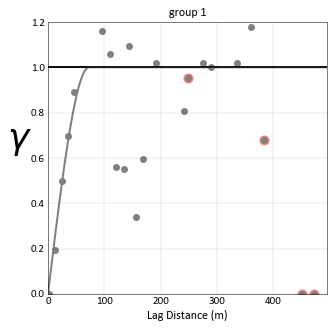

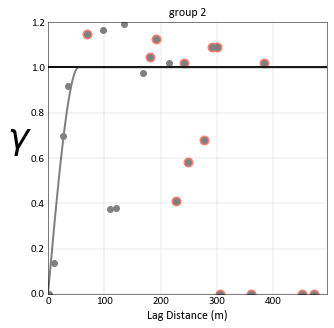

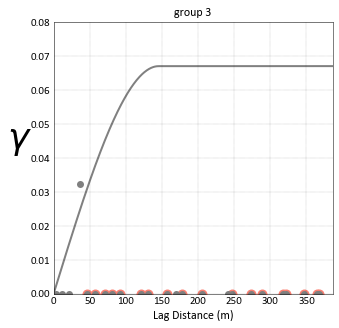

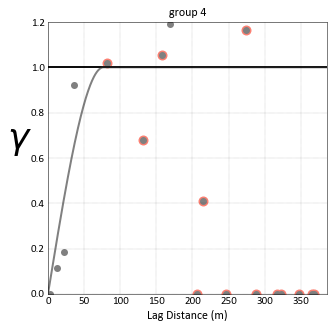

In [26]:
for ind in [1,2,3,4,]:
    varfl = gs.DataFile('Outputs/out_fl_{}.out'.format(ind))
    modelfl=gs.DataFile('Outputs/model_file_out_{}.out'.format(ind))
    if ind == 3:
        _ = gs.variogram_plot(varfl, title='group {}'.format(ind), grid=True, ms=7, figsize=(5,5), )
        gs.variogram_plot(modelfl, experimental=False, ax= _, output_file='images/var_{}.png'.format(ind), lw=2, ylim=[0,0.08])
    else:    
        _ = gs.variogram_plot(varfl, title='group {}'.format(ind), grid=True, ms=7, figsize=(5,5))
        gs.variogram_plot(modelfl, experimental=False, ax= _, output_file='images/var_{}.png'.format(ind), lw=2)

In [27]:
def aniso_support(vario_str):
    a1 = float(vario_str[1].split()[2])
    a2 = float(vario_str[1].split()[3])
    a3 = float(vario_str[1].split()[4])
    r1 = float(vario_str[2].split()[0])/float(vario_str[2].split()[1])
    r2 = float(vario_str[2].split()[0])/float(vario_str[2].split()[2])
    r = float(vario_str[2].split()[0])
    
    return a1, a2, a3, r1, r2, r

In [28]:
c = [12, 12, 12, 12]

In [29]:
parstr = """                        rbfdfmod
                        ********

START OF PARAMETERS:
{flname}                -file with input dataset
1  2 0  4               - column for x, y, z, indicator data
-999                     - trimming value
1 1                  -ncats, category indicator
keyout.dat               -file with the keyout model
1  1                     - column for keyout variable, value to keep
{grid}
1  {C}               -RBFinterp type (1:direct, 2:POU)-NOTE 1, trained C parameter(s)-NOTE 3
1  0.001                 - RBF kernel (NOTE 2), Nugget Effect
0 {support}  1000              - Support (0:manual,1:auto) - NOTE 2, support distance, extrapolation distance
0                        -Use different anisotropy for each category? (1=Yes,0=No) - NOTE 4
0  0  0                  - Anisotropic orientations (str,dip,plunge) / Cat1
1  1                     - Anisotropic ratios (minor/major, vertical/major, <= 1.0)
2    6                   -Ouput: (1) indicators or (2) signed distacnce function, numthreads for parallel SDF
{outfl}                -file for interpolated output
*** BPT parameter section: ***  
95  0.06  1              -Partition paramters: dpc, d overlap, weight func (1 or 2, see paper)
 0.5 0.5 0.5             - final partition overlap in x, y, z directions
0                        -read BPT parameters from file(1=Yes,0=No) - NOTE 6
BPT_bounds.out           -file with partition boundaries
BPT_aniso_cat2_ref4.out  -file(s) with anisotropy for each category

NOTES:
1  -   the supported types of interpolation in this program are 1:direct (slow for > 15k data),
       2:POU (>15k data). Regardless of interpolation type, all lines are required (do not remove
       lines from this parameter file,  simply ignore those parameters)
2  -   Valid Kernels: 1:Gaussian,2:Cubic,3:Wendland C2,4:Linear,5:Spherical
       Caution: NE with RBFs is problematic. Use with Caution. A small (0.0001) NE added to Gaussian by default
       For a kernel that has a support parameter (Gaussian, Wendlands), the support distance defines the
       range at which the influence of points is negligeble. Setting the support option to 1 estimates
       the support distance from the max distance from any grid cell to its nearest data, over the whole domain.
       In the case of partition of unity interpolation, this parameter is estimated locally for each
       partition.
3  -   One C-parameter is required for each category. Specifying the value of the trained C paramter will
       interpolate the SDF problem by considering that parameter in the calculated distance function.
       The interpolated SDF from this program will have the correct volume according to that trained C parameter
       (Wilde and Deutsch, 2011)
4  -   If this option is set to 1, you must provide anisotropic parameter sets for each category
       indicated on line 8 on the following lines by reproducing the following 2 lines and pasting them
       immediately below for each needed set of anisotropic parameters.
       0  0  0                        - Anisotropic orientations (str,dip,plunge) / Cat_N
       1  1                           - Anisotropic ratios (minor/major, vertical/major, <= 1.0)
5  -   The resulting .h5 file will contain all required configuration information including solved weights
       so that the interpolant can be re-evaluated without re-solving the problem. This will include
       all partitioning and configuration properties.. to be used in the rbfextract program 
6  -   Set option to 1 to read boundaries and anisotropic partition parameters from a trained file output by
       the rbfiterref program. Use this option to read in those parameters and interpolate the problem with the
       trained c parameter from the rbfuncert program.



"""

for ind in [1,2,3,4,]:
    
    f = open("Outputs/var_model_{}.out".format(ind), "r")
    varstr = f.readlines()
    
    a1, a2, a3, r1, r2, r = aniso_support(varstr)
    
    parstr1 = parstr.format(
                           grid=grid,
                           flname=dfg['g{}'.format(ind)].flname,
                           C='{} {} {} {}'.format(c[0], c[1], c[2], c[3]),
                           support=r,
                           outfl='Outputs/out_sd_{}.out'.format(ind),
                          )

    rbfdfmod.run(parstr=parstr1, liveoutput=True)

Calling:  ['RBFDFMOD/rbfdfmod.exe', 'temp']
 rbfdfmod, version :  2.00
Datafile: data/data_g1                            
 xcol,ycol and zcol and datcol:   1  2  0  4
 interpolation is 2D, since zcol = 0 
 trimming limit:         -999.00
 categories to model:          1
 nx, xmn, xsiz =  147        58.5000           3.0000
 ny, ymn, ysiz =  174        54.5000           3.0000
 nz, zmn, zsiz =    1         0.5000           1.0000
 Interpolation Type:  Direct              
 Kernel Type: Gaussian            
Using the defined support     72.870
Will only consider grid locations falling within this
  distance from data:    1000.0000    
 Using one set of aniostropic properties for all categories 
 Using the following for all categories: 
Using these angles:          0.0000000       0.0000000       0.0000000    
 minor/major, vert/major:    1.0000000       1.0000000    
Exporting the signed distance function values for each indicator 
File to write outputs to: Outputs/out_sd_1.out
 
 Buildi

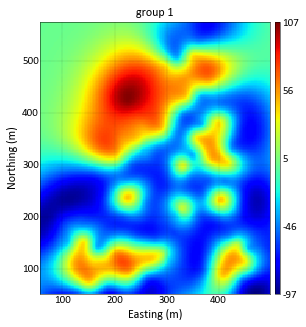

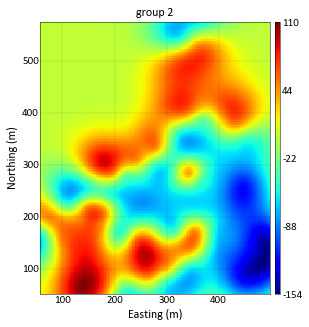

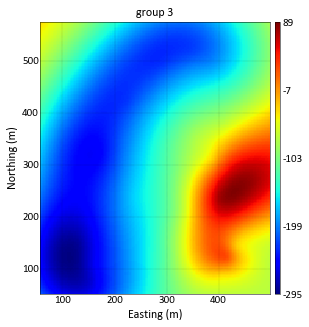

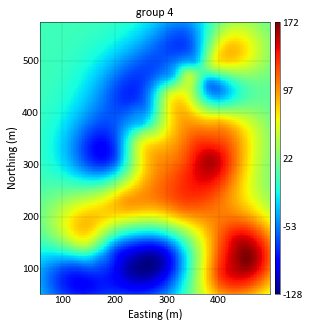

In [30]:
g_int = {}
for ind in [1,2,3,4,]:
    sd_grid = gs.DataFile('Outputs/out_sd_{}.out'.format(ind), griddef=grid)
    g_int[ind] = sd_grid
    _ = gs.slice_plot(sd_grid, 
                      griddef=grid,
                      title='group {}'.format(ind),
                      cmap='jet', 
                      figsize=(5,5), 
                      grid=True, 
                      output_file='images/int_g{}.png'.format(ind))

In [31]:
nreals = 10

In [32]:
def gauss_tr_varg(varg_file):
    f = open(varg_file, "r")
    varstr = f.readlines()
    
    for idx, i in enumerate(varstr):
        if idx == 0:
            l = i.split()
            l[1] = " 0.0000009 "
            l[-1] = " \n "
            varstr[idx] = ' '.join(l)
        else:
            l = i.split()
            if l[0] == '1':
                l[0] = " 3 "
                l[-1] = " \n "
                varstr[idx] = ' '.join(l)
                
    return ''.join(varstr)

In [33]:
gauss_tr_varg('Outputs/var_model_1.out')

'2  0.0000009  -nst, nugget  \n  3  0.60300 0.00000 0.00000 0.00000 -it,cc,azm,dip,tilt  \n          72.87000         72.87000         72.87000    -a_hmax, a_hmin, a_vert (ranges)\n 3  0.39700 0.00000 0.00000 0.00000 -it,cc,azm,dip,tilt  \n          72.82000         72.82000         72.82000    -a_hmax, a_hmin, a_vert (ranges)\n'

In [34]:
usgsimpar = '''
               Parameters for UltimateSGSIM
               ****************************

START OF MAIN:
{nreals}                      -number of realizations to generate, 0=kriging
1                             -number of variables being simulated
0                             -number of rock types to consider
{seed}                         -random number seed
{griddef}
{outfl}                     -file for simulation output
0                             -  output format: (0=reg, 1=coord, 2=bin)
impute.out                    -file for imputed values in case of heterotopic samples
0                             -debugging level: 0,1,2,3
sgsim.dbg                     -file for debugging output

START OF SRCH:
12                            -number of data to use per variable
1000 1000 1000            -maximum search radii (hmax,hmin,vert)
0.0    0.0    0.0             -angles for search ellipsoid
0                             -sort by distance (0) or covariance (1)
1 1 1                         -if sorting by covariance, indicate variogram rock type, head, tail to use

START OF VARG:
1                             -number of variograms
0  1  1                       -rock type, variable 1, variable 2
{varg}
'''

callpars = []

groups = [1,2,3,4]

for g in groups:
    
    usgsimpars = {
        'seed':gs.rseed(),
        'nreals':str(nreals),
        'griddef':grid,
        'outfl':'Outputs/uncondsim_{}.out'.format(g),
        'varg':gauss_tr_varg("Outputs/var_model_{}_t.out".format(g))
        #varg':vario_groups[g].model
    }
    
    callpars.append({'parstr':usgsimpar.format(**usgsimpars), 'parfile':'Outputs/usgsimpar_{}.par'.format(g)})

    
usgsim = gs.Program(program='USGSIM/usgsim', parstr='USGSIM/usgsim.par')
gs.runparallel(usgsim, callpars)

Creating parallel processes
Pool assembled, asynchronously processing
Asynchronous execution finished.


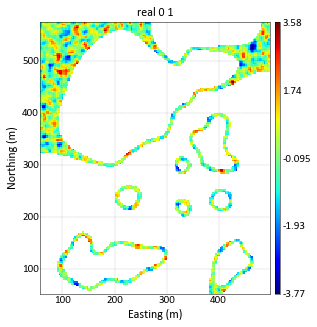

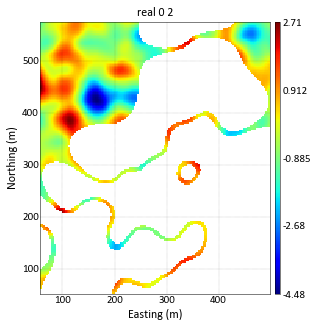

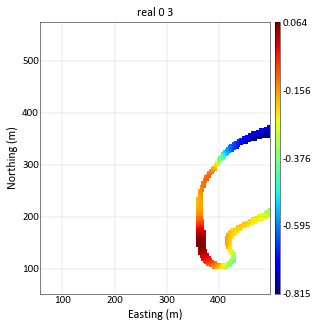

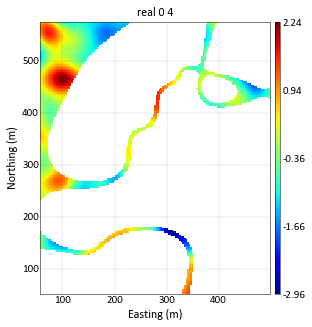

In [35]:
for i, g in enumerate(groups):
    
    g_var = g_int[g]['Cat_1'].values
    
    sgsim = gs.DataFile(flname='Outputs/uncondsim_{}.out'.format(g))
    sgsim_vals = np.reshape(sgsim.data.values, (grid.count(), nreals), order='F')
    sgsim_pd = pd.DataFrame(columns=['real {}'.format(c) for c in range(nreals)], data=sgsim_vals)
    #gs.write_hvtk(sgsim_pd, 'E:/Outputs/sgsim_g{}.xdmf'.format(g), griddef)
    
    a = np.where(np.logical_and(g_var < c[i], g_var > -c[i]), sgsim_pd['real 0'], float('nan'))
    
    _ = gs.slice_plot(a, 
                      griddef=grid,
                      title='real 0 {}'.format(g),
                      cmap='jet', 
                      figsize=(5,5), 
                      grid=True, 
                      output_file='images/real{}_simu_var.png'.format(g))

In [36]:
sdfclippar = '''
                         Parameters for SDFCLIP
                         **********************
START OF PARAMETERS:
{est}                           -file with kriged signed distance function
1                                  - column with estimates
{sim}                          -file with simulated threshold model
1                                  - column with value
1 -{c} {c}                         - convert to uniform (1=yes) with range min max
-10e30 10e30                         -trimming limits
{nx} {ny} {nz} {nreals}                     -nx, ny, nz, nrealization
1                                -cell volume
{outind}                         -file for output indicator model
{volout}                         -file for volume summary
'''

callpars = []

groups = [1,2,3,4]

for i, g in enumerate(groups):
        
    sdfclippars = {
        'nreals':str(nreals),
        'est':'Outputs/out_sd_{}.out'.format(g),
        'sim':'Outputs/uncondsim_{}.out'.format(g),
        'c':c[i],
        'outind':'Outputs/clip_ind_{}.out'.format(g),
        'volout':'Outputs/clip_vol_{}.out'.format(g),
        'nx':grid.nx,
        'ny':grid.ny,
        'nz':grid.nz,
    }
    
    callpars.append({'parstr':sdfclippar.format(**sdfclippars), 'parfile':'SDFCLIP/sdfclippar_{}.par'.format(g)})

    
sdfclip = gs.Program(program='SDFCLIP/sdfclip', parstr='SDFCLIP/sdfclippar.par')
gs.runparallel(sdfclip, callpars)

Creating parallel processes
Pool assembled, asynchronously processing
Asynchronous execution finished.


In [37]:
groups_dic = {}
for g in [1,2,3,4]:
    grupo = gs.DataFile(flname='Outputs/clip_ind_{}.out'.format(g))
    v = grupo['Indicator'].values
    r = np.reshape(v, (grid.count(), nreals), order='F')
    df = pd.DataFrame(r, columns=['real_{}'.format(i) for i in range(nreals)])
    groups_dic[g] = df

ValueError: cannot reshape array of size 200692 into shape (25578,10)

In [ ]:
for i in [1,2,3,4]:
    _ = gs.slice_plot(groups_dic[i],
                      griddef=grid,
                      var='real_0', 
                      cmap='jet', 
                      figsize=(5,5), 
                      grid=True, 
                      output_file='images/g{}_sim_var.png'.format(i))

In [ ]:
reals_pd = []
for real in range(nreals):
    reals_pd.append(np.ones(len(groups_dic[1]))*float('nan'))
reals_pd = np.reshape(reals_pd, (grid.count(), nreals), order='F')

In [ ]:
for real in range(nreals):
    for value in range(len(groups_dic[1])):

        if groups_dic[1].iloc[value][real] == 1 and groups_dic[2].iloc[value][real] == 1:
            reals_pd[value][real] = 2
        if groups_dic[1].iloc[value][real] == 1 and groups_dic[2].iloc[value][real] == 0:
            reals_pd[value][real] = 3
        if groups_dic[1].iloc[value][real] == 0 and groups_dic[3].iloc[value][real] == 0:
             reals_pd[value][real] = 4
        if groups_dic[1].iloc[value][real] == 0 and groups_dic[3].iloc[value][real] == 1 and groups_dic[4].iloc[value][real] == 1:
             reals_pd[value][real] = 1
        if groups_dic[1].iloc[value][real] == 0 and groups_dic[3].iloc[value][real] == 1 and groups_dic[4].iloc[value][real] == 0:
             reals_pd[value][real] = 5

In [ ]:
reals = pd.DataFrame(reals_pd, columns=['real_{}'.format(i) for i in range(nreals)])

In [ ]:
for i in range(nreals):
    a = np.where(np.isfinite(jur_mask['Cat']), reals['real_{}'.format(i)], float('nan'))
    _ = gs.slice_plot(a, 
                      griddef=grid,
                      cmap='jet', 
                      catdict=cat_dict, 
                      figsize=(5,5), 
                      grid=True, 
                      output_file='images/geomodel_{}_sim_var.png'.format(i))

In [ ]:
shanon_entropy = entropy(reals)

In [ ]:
a = np.where(np.isfinite(jur_mask['Cat']),shanon_entropy, float('nan'))
_ = gs.slice_plot(a, 
                      griddef=grid,
                      cmap='jet', 
                      figsize=(5,5), 
                      grid=True, 
                      output_file='images/jura_entropy_sim_var.png')